In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from tree_based_models import (
    model_selection_using_kfold_surv,
    model_selection_using_kfold,
    get_model,
)
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxPHSurvivalAnalysis, IPCRidge, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from feature_engineering import (
    one_hot_aggregate,
    add_cytogenetic_features,
    create_molecular_feat,
)

from sksurv.util import Surv
from deepsurv import model_selection_using_kfold_deepsurv, DeepSurv, train_deepsurv

## Data Loading

In [37]:
# Clinical Data
clinical_train = pd.read_csv("data/X_train/clinical_train.csv")
clinical_test = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
molecular_train = pd.read_csv("data/X_train/molecular_train.csv")
molecular_test = pd.read_csv("data/X_test/molecular_test.csv")

target_train = pd.read_csv("data/X_train/target_train.csv")

# Preview the data
clinical_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [38]:
train = pd.concat(
    [
        clinical_train.set_index("ID"),
        target_train.set_index("ID"),
    ],
    axis=1,
)
train = train[~train["OS_YEARS"].isna()]
train.head()

,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,OS_YEARS,OS_STATUS
ID,,,,,,,,,,
P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.115068,1.0
P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",4.928767,0.0
P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",2.043836,0.0
P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",2.476712,1.0
P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",3.145205,0.0


## Baseline using simple features

Define base features

In [64]:
target = "OS_YEARS"
base_features = ["BM_BLAST", "WBC", "HB", "PLT"]
model_type = "ridge"

Model not censored CATBoosting

In [65]:
model_selection_using_kfold(
    data=train.reset_index(),
    target=target,
    features=base_features,
    model_type=model_type,
    feat_engineering=None,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    log=False,
)

Fold 1 - IPCW C-index (Train: 0.6676 | Test: 0.6587)
Fold 2 - IPCW C-index (Train: 0.6681 | Test: 0.6570)
Fold 3 - IPCW C-index (Train: 0.6632 | Test: 0.6844)
Fold 4 - IPCW C-index (Train: 0.6654 | Test: 0.6639)
Fold 5 - IPCW C-index (Train: 0.6676 | Test: 0.6651)
Fold 6 - IPCW C-index (Train: 0.6656 | Test: 0.6702)
IPCW C-index: 0.6665 (± 0.0091) [Min: 0.6570 ; Max: 0.6844]
No possible to get feature importance for this model.


## Feature Engineering 

Define some feature engineering : 
- Molecular data One Hot Encoding
- Decode cytogenetic data
- Add Molecular Mutations informations

In [43]:
def feat_engineering(
    data: pd.DataFrame,
    molecular_data: pd.DataFrame,
    fill_not_molecular=False,
) -> tuple[pd.DataFrame, list]:
    """Apply domain-specific feature engineering for DeepSurv."""

    # Identify patients with no molecular data
    ids_not_molecular = [
        pid for pid in data.index.unique() if pid not in molecular_data["ID"].unique()
    ]
    not_molecular = data[data.index.isin(ids_not_molecular)]

    # 1. Molecular Features
    # Aggregates mutation-based numerical features (e.g., count, mean VAF, length)
    data, molecular_feat = create_molecular_feat(
        data=data, molecular_data=molecular_data
    )

    # 2. Cytogenetic Features
    # Adds features describing cytogenetic abnormalities (e.g., complex karyotype)
    data, col_clinical = add_cytogenetic_features(data)

    # 3. One-Hot Encoding of Molecular Categories
    # EFFECT: mutation effect types (e.g., missense, frameshift)
    data, categories = one_hot_aggregate(molecular_data, data, "EFFECT")

    # CHR: chromosome-level distribution of mutations
    data, chromosomes = one_hot_aggregate(
        molecular_data, data, "CHR", fillna_value="no_chr"
    )

    # GENE: gene-level presence/absence indicators
    data, genes = one_hot_aggregate(
        molecular_data, data, "GENE", fillna_value="no_gene"
    )

    # Collect all generated feature names
    new_feats = (
        list(col_clinical)
        + list(molecular_feat)
        + list(categories)
        + list(chromosomes)
        + list(genes)
    )

    # Recompute cytogenetic features for non-molecular patients
    not_molecular, _ = add_cytogenetic_features(not_molecular)

    # Fill missing molecular features with 0 for non-molecular patients
    if fill_not_molecular:
        data = pd.concat([data, not_molecular])
        data[
            list(molecular_feat) + list(categories) + list(chromosomes) + list(genes)
        ] = data[
            list(molecular_feat) + list(categories) + list(chromosomes) + list(genes)
        ].fillna(
            0
        )

    return data, new_feats

Add new features to the data

In [44]:
# Apply Feature Engineering
test = clinical_test.set_index("ID").copy()

train, feat_train = feat_engineering(
    data=train, molecular_data=molecular_train, fill_not_molecular=True
)
test, feat_test = feat_engineering(
    data=test, molecular_data=molecular_test, fill_not_molecular=True
)

feats = [ft for ft in feat_test if ft in feat_train]

Define Features

In [45]:
# Define Model Inputs
target = "OS_YEARS"
features = base_features + feats
model_type = "cat"  # Parameters and Model based on previous challenges knowledge tree_based_models/initialise_model.py

Perform Cross Validation

Fold 1 - IPCW C-index (Train: 0.7474 | Test: 0.6807)
Fold 2 - IPCW C-index (Train: 0.7451 | Test: 0.6976)
Fold 3 - IPCW C-index (Train: 0.7423 | Test: 0.7291)
Fold 4 - IPCW C-index (Train: 0.7457 | Test: 0.7187)
Fold 5 - IPCW C-index (Train: 0.7411 | Test: 0.7191)
Fold 6 - IPCW C-index (Train: 0.7469 | Test: 0.6994)
IPCW C-index: 0.7075 (± 0.0164) [Min: 0.6807 ; Max: 0.7291]

Top 20 important features:
['PLT', 'HB', 'BM_BLAST', 'VAF', 'TP53', 'Nmut', '21', 'non_synonymous_codon', 'num_monosomies', 'WBC', '17', 'SF3B1', 'NFE2', 'sex', 'num_trisomies', '1', 'abnormal_fraction', 'ASXL1', '20', 'RUNX1']


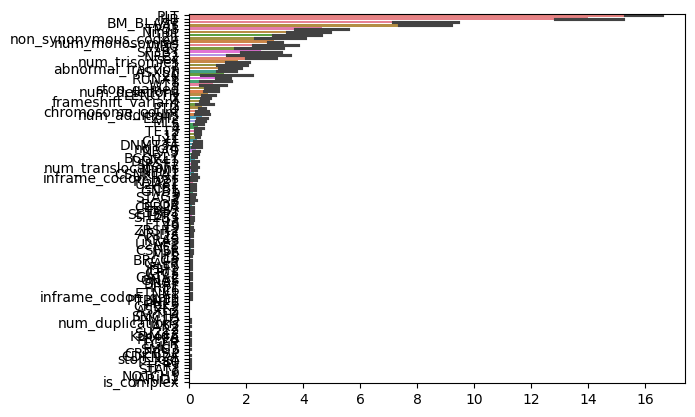

In [46]:
# Model Selection with Cross-Validation
model_selection_using_kfold(
    data=train.reset_index(),
    target=target,
    features=features,
    model_type=model_type,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    scale=True,
    n_importance=20,
)

## Survival Model

In [47]:
# Select and Configure Tree-Based Model

# Test Random Survival Forest
model_cls = RandomSurvivalForest

model_params = {
    "n_estimators": 150,
    "max_depth": 15,
    "min_weight_fraction_leaf": 0.005,
    "random_state": 42,
}

In [48]:
status = "OS_STATUS"

In [49]:
# Model Selection via K-Fold Cross Validation
model_selection_using_kfold_surv(
    data=train.reset_index(),
    target=target,
    status=status,
    model_cls=model_cls,
    params=model_params,
    features=features,
    feat_engineering=None,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    log=False,
)

Fold 1 - Concordance Index (Train: 0.7789 | Test: 0.6767)
Fold 2 - Concordance Index (Train: 0.7738 | Test: 0.7197)
Fold 3 - Concordance Index (Train: 0.7730 | Test: 0.7311)
Fold 4 - Concordance Index (Train: 0.7729 | Test: 0.7254)
Fold 5 - Concordance Index (Train: 0.7732 | Test: 0.7331)
Fold 6 - Concordance Index (Train: 0.7752 | Test: 0.7099)
Concordance Index: 0.7160 (± 0.0192) [Min: 0.6767 ; Max: 0.7331]
Feature importance not available for this model.


## Deep Surv

In [62]:
# DeepSurv hyperparameters
hidden_layers_sizes = [128, 64]
dropout = 0.5
n_splits = 6
n_epochs = 50
lr = 1e-4
weight_decay = 1e-5

In [63]:
# Model Selection with Cross-Validation
results = model_selection_using_kfold_deepsurv(
    data=train.reset_index(),
    features=features,
    target=target,
    status=status,
    hidden_layers_sizes=hidden_layers_sizes,
    dropout=dropout,
    n_splits=n_splits,
    n_epochs=n_epochs,
    lr=lr,
    weight_decay=weight_decay,
    unique_id="ID",
    device="cpu",
)

Fold 1 - IPCW C-index (Train: 0.7604 | Test: 0.7146)
Fold 2 - IPCW C-index (Train: 0.7582 | Test: 0.7144)
Fold 3 - IPCW C-index (Train: 0.7585 | Test: 0.7265)
Fold 4 - IPCW C-index (Train: 0.7625 | Test: 0.7047)
Fold 5 - IPCW C-index (Train: 0.7638 | Test: 0.6920)
Fold 6 - IPCW C-index (Train: 0.7603 | Test: 0.7155)

Concordance Index (Test, IPCW): 0.7113 ± 0.0107 [Min: 0.6920 ; Max: 0.7265]
